In [538]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from difflib import SequenceMatcher as SM
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

%matplotlib inline

In [84]:
import sys    
reload(sys)  
sys.setdefaultencoding('utf8')

In [540]:
def smote(X, y, target, k=None):
    """
    INPUT:
    X, y - your data
    target - the percentage of positive class 
             observations in the output
    k - k in k nearest neighbors
    OUTPUT:
    X_oversampled, y_oversampled - oversampled data
    `smote` generates new observations from the positive (minority) class:
    For details, see: https://www.jair.org/media/953/live-953-2037-jair.pdf
    """
    if target <= sum(y)/float(len(y)):
        return X, y
    if k is None:
        k = len(X)**.5
    # fit kNN model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X[y==1], y[y==1])
    neighbors = knn.kneighbors()[0]
    positive_observations = X[y==1]
    # determine how many new positive observations to generate
    positive_count = sum(y)
    negative_count = len(y) - positive_count
    target_positive_count = target*negative_count / (1. - target)
    target_positive_count = int(round(target_positive_count))
    number_of_new_observations = target_positive_count - positive_count
    # generate synthetic observations
    synthetic_observations = np.empty((0, X.shape[1]))
    while len(synthetic_observations) < number_of_new_observations:
        obs_index = np.random.randint(len(positive_observations))
        observation = positive_observations[obs_index]
        neighbor_index = np.random.choice(neighbors[obs_index])
        neighbor = X[neighbor_index]
        obs_weights = np.random.random(len(neighbor))
        neighbor_weights = 1 - obs_weights
        new_observation = obs_weights*observation + neighbor_weights*neighbor
        synthetic_observations = np.vstack((synthetic_observations, new_observation))

    X_smoted = np.vstack((X, synthetic_observations))
    y_smoted = np.concatenate((y, [1]*len(synthetic_observations)))

    return X_smoted, y_smoted

In [2]:
df = pd.read_json('train_new.json')

In [3]:
print df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14337 entries, 0 to 14336
Data columns (total 44 columns):
acct_type             14337 non-null object
approx_payout_date    14337 non-null int64
body_length           14337 non-null int64
channels              14337 non-null int64
country               14256 non-null object
currency              14337 non-null object
delivery_method       14321 non-null float64
description           14337 non-null object
email_domain          14337 non-null object
event_created         14337 non-null int64
event_end             14337 non-null int64
event_published       14238 non-null float64
event_start           14337 non-null int64
fb_published          14337 non-null int64
gts                   14337 non-null float64
has_analytics         14337 non-null int64
has_header            8928 non-null float64
has_logo              14337 non-null int64
listed                14337 non-null object
name                  14337 non-null object
name_length      

In [86]:
df['acct_type'].unique()

array([u'fraudster_event', u'premium', u'spammer_warn', u'fraudster',
       u'spammer_limited', u'spammer_noinvite', u'locked', u'tos_lock',
       u'tos_warn', u'fraudster_att', u'spammer_web', u'spammer'], dtype=object)

In [4]:
frauds = df['acct_type'].str.contains('fraudster')

In [5]:
df['fraud'] = frauds

In [47]:
df.columns

Index([u'acct_type', u'approx_payout_date', u'body_length', u'channels', u'country', u'currency', u'delivery_method', u'description', u'email_domain', u'event_created', u'event_end', u'event_published', u'event_start', u'fb_published', u'gts', u'has_analytics', u'has_header', u'has_logo', u'listed', u'name', u'name_length', u'num_order', u'num_payouts', u'object_id', u'org_desc', u'org_facebook', u'org_name', u'org_twitter', u'payee_name', u'payout_type', u'previous_payouts', u'sale_duration', u'sale_duration2', u'show_map', u'ticket_types', u'user_age', u'user_created', u'user_type', u'venue_address', u'venue_country', u'venue_latitude', u'venue_longitude', u'venue_name', u'venue_state', u'fraud'], dtype='object')

In [54]:
sum(df['fraud'])

1293

In [55]:
len(df['fraud']) - sum(df['fraud'])

13044

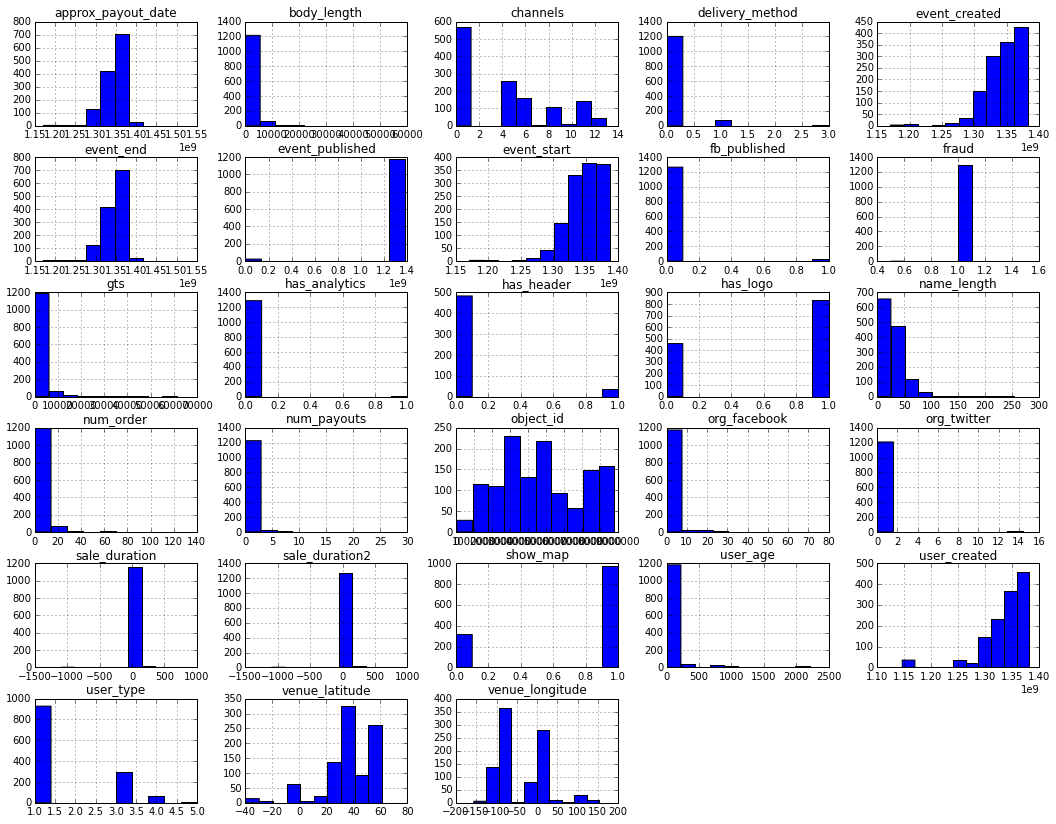

In [61]:
df[df['fraud']==True].hist(figsize=(18,14))
plt.show()

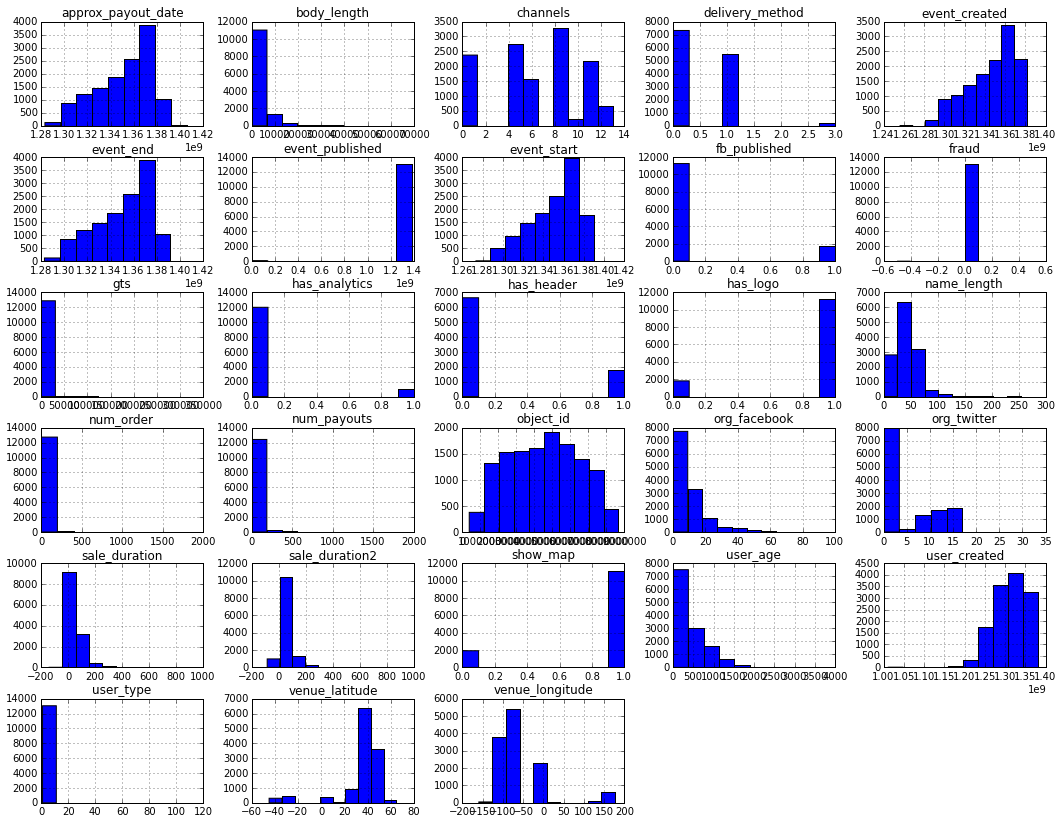

In [62]:
df[df['fraud']==False].hist(figsize=(18,14))
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x26dea7f50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x297f27450>]], dtype=object)

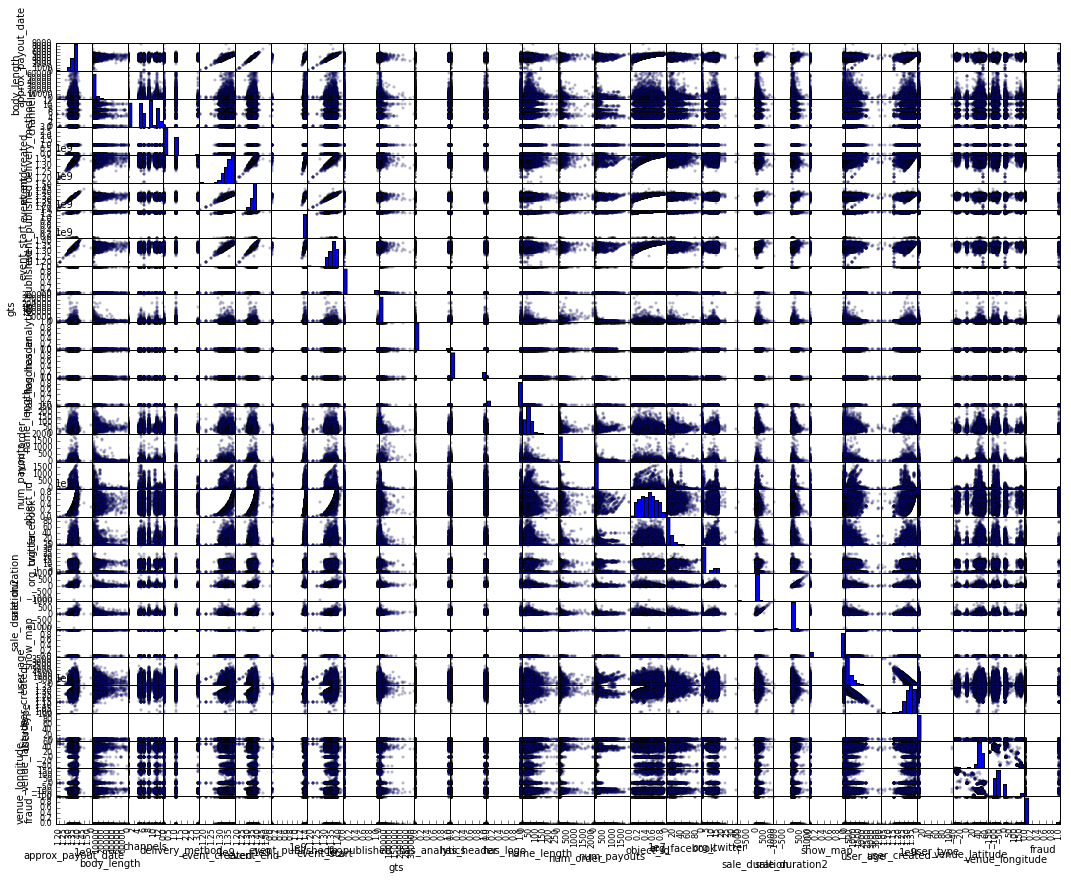

In [74]:
pd.tools.plotting.scatter_matrix(df, alpha=0.2, figsize=(18,14))

In [80]:
df.info()

In [6]:
y = df['fraud'].values

In [38]:
X = df.drop(['fraud'], axis=1)

In [39]:
X = X.drop(['acct_type'], axis=1)

In [15]:
import time
time.strftime('%B %d %Y', '1259613950')

TypeError: argument must be 9-item sequence, not str

In [20]:
datetime.datetime.fromtimestamp(int("1284101485")).strftime('%Y-%m-%d %H:%M:%S')

(<function __main__.<lambda>>, 0        1259613950
 1        1280942776
 2        1272559388
 3        1283870102
 4        1288984065
 5        1268579110
 6        1233437951
 7        1288276103
 8        1294428121
 9        1288276103
 10       1231436612
 11       1258180664
 12       1225799820
 13       1255857361
 14       1279046075
 15       1264709634
 16       1264709634
 17       1297479866
 18       1236178830
 19       1297470242
 20       1297501981
 21       1264487280
 22       1259603019
 23       1259786059
 24       1289584604
 25       1252729123
 26       1295576777
 27       1277913245
 28       1279136852
 29       1228711936
             ...    
 14307    1308777954
 14308    1326959165
 14309    1328868816
 14310    1355437639
 14311    1358378426
 14312    1358277129
 14313    1308699612
 14314    1290081059
 14315    1332158693
 14316    1358948648
 14317    1294615173
 14318    1358975276
 14319    1327327750
 14320    1359114737
 14321    1264635720
 143

In [22]:
type(df['user_created'][0])

numpy.int64

In [24]:
df_countries = pd.get_dummies(df['country'])

In [26]:
df_countries.drop(['US'], axis=1, inplace=True)

In [40]:
X = pd.concat((X, df_countries), axis=1)

In [41]:
X.drop(['country'], axis=1, inplace=True)

In [35]:
df_currency = pd.get_dummies(df['currency'])

In [36]:
df_currency.drop(['USD'], axis=1, inplace=True)

In [37]:
df_currency.head()

,AUD,CAD,EUR,GBP,MXN,NZD
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,1,0,0,0
4,0,0,0,0,0,0


In [43]:
X = pd.concat((X, df_currency), axis=1)

In [45]:
X.drop(['currency'], axis=1, inplace=True)

In [49]:
X.drop(['description'], axis=1, inplace=True)

In [61]:
X.head()

,approx_payout_date,body_length,channels,delivery_method,email_domain,event_created,event_end,event_published,event_start,fb_published,...,VE,VI,VN,ZA,AUD,CAD,EUR,GBP,MXN,NZD
0,1266062400,3852,5,0,gmail.com,1262739706,1265630400,1263109838,1265594400,0,...,0,0,0,0,0,0,0,0,0,0
1,1296720000,3499,0,1,ruf.org,1293832670,1296288000,1293833295,1296255600,0,...,0,0,0,0,0,0,0,0,0,0
2,1296172800,2601,8,1,pvsd.k12.ca.us,1291090956,1295740800,1291091908,1295713800,0,...,0,0,0,0,0,0,0,0,0,0
3,1388966400,12347,6,1,irishtabletennis.com,1360681570,1388534400,1360683446,1360702800,0,...,0,0,0,0,0,0,1,0,0,0
4,1297900800,2417,11,0,artsandbusinesscouncil.org,1291994666,1297468800,1291994966,1297440000,1,...,0,0,0,0,0,0,0,0,0,0


In [87]:
X['len_desc'] = map(lambda x: len(x), df['description'])

In [90]:
X['len_pp'] = map(lambda x: len(x), df['previous_payouts'])

In [78]:
for i in df['previous_payouts'][df['fraud']==1]: 
    print len(i)

0
0
2
0
0
0
29
1
29
0
32
0
0
0
0
0
0
0
0
0
11
0
0
1
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
2
3
0
2
0
0
3
0
9
6
0
0
1
0
0
29
1
0
1
0
0
0
0
0
0
0
3
0
0
0
1
0
0
0
1
6
0
2
3
0
0
0
0
0
0
0
0
0
0
0
0
7
1
0
0
0
0
0
0
2
0
0
0
0
0
21
1
0
2
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
3
0
0
1
0
0
1
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
5
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
22
1
8
3
3
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
5
0
0
0
0
0
0
0
0
0
0
0
2
1
0
24
0
0
5
1
0
0
9
0
29
29
0
6
29
29
0
10
0
0
0
0
2
5
2
1
0
0
0
0
1
1
0
0
0
0
0
0
0
24
24
0
8
0
0
3
1
0
0
3
0
1
0
24
21
0
0
0
0
0
0
0
2
0
0
0
0
0
0
2
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
22
14
1
0
3
0
0
0
0
2
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
3
0
2
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
0
1
0
2
9
2
0
0
2
0
1
1
0
1
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
14
0
0
0
0
0
2
2
0
9
9
29
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
3
0
29
1
1
0
0
0
1
0


In [510]:
for i in df['previous_payouts'][df['fraud']==0]: 
    print len(i)

49
36
21
49
5
15
470
2
470
96
262
50
63
8
1264
1264
1
11
11
1
31
13
207
2
406
192
216
15
3
44
24
2
49
6
2
14
12
6
1
2
4
2
7
2
77
3
14
1
10
1
17
72
1264
57
1
1
57
3
3
12
11
77
2
1
9
10
13
143
1
60
60
4
3
65
2
1
11
133
31
5
1
1
1666
5
394
55
4
434
4
43
157
32
4
12
3
24
3
41
148
253
5
3
3
4
31
121
4
45
9
1
1
2
2
6
8
59
13
126
1
20
3
43
2
48
63
148
1972
228
1
12
151
1
15
9
11
33
11
11
13
2
1
174
17
79
151
7
15
1
35
35
2
5
7
8
3
95
1
293
13
1
145
2
2
40
6
12
19
2
3
5
1
35
9
141
20
5
1
56
1
6
16
7
6
35
65
8
4
4
5
136
32
7
9
32
1
1
4
82
2
25
81
47
7
1
152
193
34
232
1
52
26
3
1
4
7
2
1666
85
2
21
1
104
1
2
11
22
6
16
1
3
9
1282
5
2
394
27
10
2
2
47
9
10
8
5
2
55
14
1
50
149
18
1
11
1113
72
88
1407
1
149
11
5
15
30
27
23
27
78
15
142
2
5
8
3
36
30
1
2
162
3
1
86
26
92
27
5
1
3
0
2
2
3
12
2
18
56
9
162
50
15
215
215
215
15
48
65
618
1
115
1
22
16
1
2
123
1
5
8
62
1
3
5
89
1
4
3
10
7
1
33
2
2
16
2
1
7
12
96
1
39
14
40
143
7
36
4
656
90
1
239
0
1
36
1
14
51
48
2
618
6
413
21
258
1
9
4
2
7
1
12
10

KeyboardInterrupt: 

In [92]:
X.drop(['previous_payouts'], axis=1, inplace=True)

In [116]:
X.iloc[:5, 20:38]

,org_desc,org_facebook,org_name,org_twitter,payee_name,payout_type,sale_duration,sale_duration2,show_map,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name
0,,0,Party Starz Ent & Diverse Int'l Group,0,,,29,33,1,"[{u'event_id': 527017, u'cost': 25.0, u'availa...",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach
1,"<p>Since 1987, RUF has ministered to students ...",0,RUF at Winthrop University,12,RUF,CHECK,28,28,0,"[{u'event_id': 786878, u'cost': 35.0, u'availa...",149,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area"
2,"<p><a href=""http://www.desiredresults.com"">www...",0,University Preparation School in collaboration...,0,University Preparation School,CHECK,54,54,0,"[{u'event_id': 787337, u'cost': 93.51, u'avail...",214,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education
3,,0,,0,,ACH,0,0,0,"[{u'event_id': 885645, u'cost': 25.0, u'availa...",889,1283870102,3,,None,NaN,NaN,None
4,"<p><font face=""Arial""><font size=""2""><strong>T...",0,Arts & Business Council of Greater Boston,0,Arts and Business Council or Greater Boston,CHECK,63,63,0,"[{u'event_id': 1114349, u'cost': 150.0, u'avai...",35,1288984065,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson


In [124]:
for i in df['org_desc'][df['fraud']==0]: 
    len(i)

In [123]:
for i in df['org_desc'][df['fraud']==1]: 
    len(i)

In [133]:
ff = 0
tf = 0
for i in df['ticket_types'][df['fraud']==1]: 
    if i == []: 
        ff +=1
    else:
        tf +=1

In [130]:
false = 0
true = 0
for i in df['ticket_types'][df['fraud']==0]: 
    if i == []: 
        false +=1
    else:
        true +=1

In [131]:
false

3

In [132]:
true

13041

In [134]:
ff

85

In [135]:
tf

1208

In [136]:
od_ff = 0
od_tf = 0
for i in df['org_desc'][df['fraud']==1]: 
    if len(i) ==0: 
        od_ff +=1
    else:
        od_tf +=1

In [137]:
print od_ff
print od_tf

850
443


In [141]:
od_false = 0
od_true = 0
for i in df['org_desc'][df['fraud']==0]: 
    if len(i) ==0: 
        od_false +=1
    else:
        od_true +=1

In [142]:
od_false

5315

In [143]:
od_true

7729

In [145]:
for i in df['org_desc'][df['fraud']==0]:
    print len(i)

554
72
0
389
129
359
93
0
93
575
0
1366
6100
7390
144
144
101
0
1033
196
0
324
0
597
311
68
0
162
0
1037
0
0
1217
364
208
1134
153
0
0
1657
409
7266
419
962
47
0
228
0
1279
0
1387
1826
144
437
3302
0
437
48
0
353
230
1311
3264
642
233
108
0
632
142
0
0
0
511
653
61
0
560
1337
0
3264
544
0
355
75
4118
0
12196
0
15
7156
352
1438
1519
494
0
493
0
300
32
308
271
300
479
1519
493
169
40
0
818
0
0
0
104
0
74
367
238
1138
0
0
1016
967
0
0
0
32
1977
314
38
1690
0
0
320
1077
0
764
2067
381
399
682
0
0
1064
221
0
0
716
0
0
0
468
0
39
0
0
1596
0
133
613
2837
965
1523
0
195
0
0
264
443
0
0
894
1161
600
0
2095
0
0
0
672
0
0
0
0
0
62
720
510
1227
77
224
889
536
161
0
0
407
791
0
0
430
501
80
0
1652
595
381
963
0
0
3179
531
0
30
0
0
121
355
0
280
0
219
125
1206
0
589
0
0
392
1355
839
0
426
0
1165
4118
616
3825
553
2246
186
359
600
0
171
0
0
1101
0
826
342
0
218
0
896
1466
0
718
239
300
0
340
1223
0
1161
1938
641
0
2374
828
83
53
0
341
138
0
0
0
214
38
0
0
402
62
0
0
0
1430
517
0
0
0
44
0
0
89
185
214

In [146]:
for i in df['org_desc'][df['fraud']==1]:
    print len(i)

0
0
0
1001
13
1687
0
0
0
0
0
0
668
0
601
0
0
0
0
0
271
31
0
0
0
667
0
0
0
0
0
0
17
0
26
0
456
1037
0
927
1568
138
0
0
116
116
0
0
419
0
0
0
340
0
0
537
571
0
0
0
0
6795
0
0
0
0
585
0
0
0
604
0
0
236
144
234
64
0
400
0
817
76
0
0
0
0
0
0
0
0
0
0
0
0
214
0
0
0
0
1421
454
368
0
0
0
0
3078
0
0
0
0
0
0
250
133
0
1388
0
234
0
0
0
135
266
222
299
75
234
186
128
0
0
778
0
0
0
778
0
215
379
65
0
0
271
48
78
66
54
0
0
0
39
116
0
0
368
0
0
0
0
0
0
0
0
0
0
0
0
295
450
626
0
0
0
0
589
0
32
0
159
0
0
44
0
0
20
0
215
98
0
0
0
0
0
0
1666
317
202
0
0
0
0
643
0
0
0
0
0
0
0
299
0
0
0
589
668
0
0
97
0
0
0
0
0
266
212
0
1762
201
0
75
38
0
0
269
0
0
0
0
0
0
2965
0
0
0
0
206
368
403
0
0
0
0
210
571
0
0
0
322
0
0
0
0
2565
0
97
0
0
186
421
0
0
45
693
0
0
0
0
406
3165
117
2965
0
0
0
116
116
0
0
0
730
0
0
0
0
0
0
0
270
368
250
0
0
0
0
0
0
2650
0
0
74
0
107
216
35
0
0
0
0
0
0
0
0
620
309
927
3213
0
0
317
298
736
0
0
0
0
0
0
0
3078
5498
211
0
153
0
1844
0
0
0
0
0
250
0
0
0
604
0
325
0
2266
1762
0
0
77
545
0
0
0
0


In [152]:
X['has_tt'] = map(lambda x: len(x) == 0, df['ticket_types'])

In [154]:
X['len_org_desc'] = map(lambda x: len(x), df['org_desc'])

In [158]:
X.drop(['org_desc', 'ticket_types'],  axis=1, inplace=True)

In [165]:
X.drop(['name'],  axis=1, inplace=True)

In [222]:
X.iloc[:5, 21:30]

,org_twitter,payee_name,payout_type,sale_duration,sale_duration2,show_map,user_age,user_created,user_type
0,0,,,29,33,1,36,1259613950,1
1,12,RUF,CHECK,28,28,0,149,1280942776,3
2,0,University Preparation School,CHECK,54,54,0,214,1272559388,3
3,0,,ACH,0,0,0,889,1283870102,3
4,0,Arts and Business Council or Greater Boston,CHECK,63,63,0,35,1288984065,3


In [173]:
X['payout_type'].get_dumme

array([u'', u'CHECK', u'ACH'], dtype=object)

In [174]:
fraud_ACH = 0
fraud_CHECK =0
fraud_blank =0
for i in df['payout_type'][df['fraud']==1]: 
    if i == 'ACH': 
        fraud_ACH +=1
    if i == 'CHECK': 
        fraud_CHECK +=1
    else:
        fraud_blank +=1

In [175]:
fraud_ACH

812

In [176]:
fraud_CHECK

30

In [177]:
fraud_blank

1263

In [178]:
ACH = 0
CHECK =0
blank =0
for i in df['payout_type'][df['fraud']==0]: 
    if i == 'ACH': 
        ACH +=1
    if i == 'CHECK': 
        CHECK +=1
    else:
        blank +=1

In [179]:
ACH

9854

In [180]:
CHECK

3148

In [181]:
blank

9896

In [182]:
df_payout = pd.get_dummies(df['payout_type'])

In [190]:
df_payout.rename(columns={'': 'BLANK'}, inplace=True)

In [191]:
df_payout.drop(['ACH'], axis=1)

,BLANK,CHECK
0,1,0
1,0,1
2,0,1
3,0,0
4,0,1
5,0,1
6,0,0
7,0,0
8,0,0
9,0,0


In [194]:
X = pd.concat((X, df_payout), axis=1)

In [ ]:
#for train, test in kf: 
    

In [308]:
rf = RandomForestClassifier()

In [344]:
model = rf.fit(X.values, y)

In [215]:
X['venue_state'].replace('Bristol, City Of', 'Bristol', inplace=True)

In [218]:
X.drop(['venue_state'], axis=1, inplace=True)

In [228]:
X[X.values == 'massage salon private house'].iloc[:, 30:40]

,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,,A1,AE,AR,AT
14336,192 Pembroke Street,GB,51.460131,-2.586503,massage salon private house,0,0,0,0,0


In [240]:
X['venue_name'].replace(9999, 'massage salon private house', inplace=True)

In [241]:
X['venue_name']

0                              INK Nightclub - South Beach
1                                  The Charleston, SC area
2                   Los Angeles County Office of Education
3                                                     None
4                                        Fish & Richardson
5                      Georgetown College Alumni Gymnasium
6                                    Danielle's Restaurant
7                                       The Magnetic Field
8                                                         
9                                       The Magnetic Field
10                                                        
11       San Francisco location given in confirmation l...
12                    Ft. Worth Business Assistance Center
13                                           Nixon Peabody
14                                             Eden Lounge
15                                Candlewood Middle School
16       Endicott College, Center for the Arts, Rose Pe.

In [242]:
ff_venue = 0
ff_novenue = 0
for i in df['venue_name'][df['fraud']==1]: 
    if i == '': 
        ff_novenue+=1
    else: 
        ff_venue+=1

In [243]:
ff_venue

1126

In [244]:
ff_novenue

167

In [245]:
venue = 0
novenue = 0
for i in df['venue_name'][df['fraud']==0]: 
    if i == '': 
        novenue+=1
    else: 
        venue+=1

In [246]:
venue

11230

In [247]:
novenue

1814

In [248]:
X.drop(['venue_name'], axis=1, inplace=True)

In [250]:
venue = 0
novenue = 0
for i in df['venue_country'][df['fraud']==1]: 
    if i == '': 
        novenue+=1
    else: 
        venue+=1

In [251]:
venue

1194

In [252]:
novenue

99

In [253]:
venue = 0
novenue = 0
for i in df['venue_country'][df['fraud']==0]: 
    if i == '': 
        novenue+=1
    else: 
        venue+=1

In [254]:
venue

12267

In [255]:
novenue

777

In [257]:
X.drop(['venue_address'], axis=1, inplace=True)

In [261]:
X.drop(['payout_type'], axis=1, inplace=True)

In [263]:
X.head(10)

,approx_payout_date,body_length,channels,delivery_method,email_domain,event_created,event_end,event_published,event_start,fb_published,...,GBP,MXN,NZD,len_desc,len_pp,has_tt,len_org_desc,BLANK,ACH,CHECK
0,1266062400,3852,5,0,gmail.com,1262739706,1265630400,1263109838,1265594400,0,...,0,0,0,3687,0,False,0,1,0,0
1,1296720000,3499,0,1,ruf.org,1293832670,1296288000,1293833295,1296255600,0,...,0,0,0,3499,49,False,554,0,0,1
2,1296172800,2601,8,1,pvsd.k12.ca.us,1291090956,1295740800,1291091908,1295713800,0,...,0,0,0,2601,36,False,72,0,0,1
3,1388966400,12347,6,1,irishtabletennis.com,1360681570,1388534400,1360683446,1360702800,0,...,0,0,0,12347,21,False,0,0,1,0
4,1297900800,2417,11,0,artsandbusinesscouncil.org,1291994666,1297468800,1291994966,1297440000,1,...,0,0,0,2417,49,False,389,0,0,1
5,1300496400,117,6,0,bluegrassstallions.com,1294421810,1300064400,1294421872,1300053600,0,...,0,0,0,117,5,False,129,0,0,1
6,1297909800,28,5,1,naboe.org,1294425018,1297477800,1294425173,1297468800,0,...,0,0,0,28,15,False,359,0,1,0
7,1296709200,974,12,0,themagnetictheatre.org,1294427837,1296277200,1294427861,1296271800,0,...,0,0,0,974,470,False,93,0,1,0
8,1298185200,4388,4,0,credosf.com,1294428122,1297753200,1294879974,1297737000,1,...,0,0,0,4098,2,False,0,0,1,0
9,1297314000,974,12,0,themagnetictheatre.org,1294428286,1296882000,1294428300,1296876600,0,...,0,0,0,974,470,False,93,0,1,0


In [283]:
df[(df['fraud'] == 1)]['email_domain'].value_counts()

gmail.com                    345
yahoo.com                    284
hotmail.com                  101
ymail.com                     44
aol.com                       40
lidf.co.uk                    35
live.com                      33
live.fr                       33
yahoo.co.uk                   26
rocketmail.com                20
yahoo.fr                      18
hotmail.co.uk                 17
ultimatewine.co.uk            13
yahoo.ca                      12
yopmail.com                   10
diversity-church.com          10
outlook.com                    9
yahoo.com.vn                   8
mail.com                       6
hotmail.fr                     6
mohmal.com                     6
aol.co.uk                      6
thinktankconsultancy.com       5
maroclancers.com               5
yahoo.de                       5
me.com                         4
live.co.uk                     4
execs.com                      4
att.net                        4
ashfordradtech.org             4
          

In [282]:
df[(df['fraud'] == 0)]['email_domain'].value_counts()

gmail.com                    2752
yahoo.com                     508
hotmail.com                   298
aol.com                       158
me.com                         71
comcast.net                    58
generalassemb.ly               58
kineticevents.com              52
live.com                       47
improvboston.com               46
sippingnpainting.com           39
claytonislandtours.com         37
racetonowhere.com              35
hotmail.co.uk                  31
greatworldadventures.com       31
shaw.ca                        28
yahoo.co.uk                    26
sbcglobal.net                  26
mac.com                        25
msn.com                        24
ymail.com                      24
guardian.co.uk                 24
joonbug.com                    23
busboysandpoets.com            21
jhilburn.com                   21
doctor.cnc.net                 20
senecalakewine.com             20
dsicomedy.com                  20
live.co.uk                     20
o-cinema.org  

In [285]:
sus_domains = ["gmail.com", "yahoo.com", "hotmail.com", "ymail.com","aol.com", \
               "lidf.co.uk"," live.com", "live.fr", "yahoo.co.uk", "rocketmail.com"]

In [293]:
X['sus_domain'] = map(lambda x: True if x in sus_domains else False, df['email_domain'])

In [294]:
X.drop(['email_domain'], axis=1, inplace=True)

In [311]:
X.iloc[:5, 16:30]

,approx_payout_date,body_length,channels,delivery_method,event_created,event_end,event_published,event_start,fb_published,gts,has_analytics,has_header,has_logo,listed,name_length
0,1266062400,3852,5,0,1262739706,1265630400,1263109838,1265594400,0,0.00,0,1,0,y,60
1,1296720000,3499,0,1,1293832670,1296288000,1293833295,1296255600,0,868.02,0,0,1,n,27
2,1296172800,2601,8,1,1291090956,1295740800,1291091908,1295713800,0,3500.00,0,NaN,0,y,28
3,1388966400,12347,6,1,1360681570,1388534400,1360683446,1360702800,0,1167.35,0,0,1,y,21
4,1297900800,2417,11,0,1291994666,1297468800,1291994966,1297440000,1,2313.15,0,0,0,y,66


In [312]:
X['listed'] = X['listed'].map({'y': 1, 'n': 0})

In [305]:
X['len_org_name'] = map(lambda x: len(x), df['org_name'])

In [306]:
X.drop('org_name', axis=1, inplace=True)

In [307]:
X.drop('payee_name', axis=1, inplace=True)

In [302]:
X['payee_name'] = map(lambda x: len(x), df['payee_name'])

In [303]:
df[df['fraud']==1][['org_name','payee_name']]

,org_name,payee_name
0,Party Starz Ent & Diverse Int'l Group,
26,,
51,CP Enterprises,robert carter
54,The London Connection,
70,Shyone Tha MainEvent,
128,THE SAM'S CAMPING AND CARAVANNING CLUB,
130,Global Gas Card,
131,ORLANDO PHYSICIANS AGAINST BONE MARROW,
140,Global Gas Card,
144,American Society of Landscape Architects,


In [321]:
X['has_header'] = X['has_header'].fillna(2)

In [325]:
X['venue_latitude'] = X['venue_latitude'].fillna(0.)
X['venue_longitude'] = X['venue_longitude'].fillna(0.)

In [328]:
X['sale_duration'] = X['sale_duration'].fillna(X['sale_duration'].mean())

In [329]:
X.isnull().sum()

approx_payout_date     0
body_length            0
channels               0
delivery_method       16
event_created          0
event_end              0
event_published       99
event_start            0
fb_published           0
gts                    0
has_analytics          0
has_header             0
has_logo               0
listed                 0
name_length            0
num_order              0
num_payouts            0
object_id              0
org_facebook          59
org_twitter           59
sale_duration          0
sale_duration2         0
show_map               0
user_age               0
user_created           0
user_type              0
venue_latitude         0
venue_longitude        0
                       0
A1                     0
                      ..
QA                     0
RO                     0
RS                     0
RU                     0
SE                     0
SG                     0
SI                     0
TH                     0
TJ                     0


In [330]:
X[['org_facebook', 'org_twitter', 'event_published', 'delivery_method']]

,org_facebook,org_twitter,event_published,delivery_method
0,0,0,1263109838,0
1,0,12,1293833295,1
2,0,0,1291091908,1
3,0,0,1360683446,1
4,0,0,1291994966,0
5,0,0,1294421872,0
6,0,0,1294425173,1
7,18,0,1294427861,0
8,0,0,1294879974,0
9,18,0,1294428300,0


In [339]:
X['org_facebook'] = X['org_facebook'].fillna(0)

In [340]:
X['org_twitter'] = X['org_twitter'].fillna(0)

In [341]:
X['event_published'] = X['event_published'].fillna(0)

In [342]:
X['delivery_method'] = X['delivery_method'].fillna(0)

In [343]:
X.isnull().sum()

approx_payout_date    0
body_length           0
channels              0
delivery_method       0
event_created         0
event_end             0
event_published       0
event_start           0
fb_published          0
gts                   0
has_analytics         0
has_header            0
has_logo              0
listed                0
name_length           0
num_order             0
num_payouts           0
object_id             0
org_facebook          0
org_twitter           0
sale_duration         0
sale_duration2        0
show_map              0
user_age              0
user_created          0
user_type             0
venue_latitude        0
venue_longitude       0
                      0
A1                    0
                     ..
QA                    0
RO                    0
RS                    0
RU                    0
SE                    0
SG                    0
SI                    0
TH                    0
TJ                    0
TR                    0
UY              

In [345]:
model = rf.fit(X.values, y)

In [346]:
model.feature_importances_

array([  1.31057744e-02,   1.22163007e-02,   7.30639928e-03,
         1.06359313e-02,   1.34131546e-02,   1.29023563e-02,
         2.41921836e-02,   1.28851338e-02,   6.02506099e-04,
         3.93743835e-02,   3.57664960e-04,   4.33155908e-03,
         2.52901849e-03,   2.16641111e-03,   1.34574781e-02,
         3.10951472e-02,   2.39344731e-02,   1.65451120e-02,
         8.68935300e-03,   9.27364181e-03,   9.45830172e-02,
         1.14701629e-01,   1.10089383e-03,   2.80961355e-02,
         2.95172638e-02,   2.55612148e-02,   1.54833335e-02,
         1.14561953e-02,   3.44387798e-04,   9.08218302e-04,
         8.25185600e-05,   1.72033716e-04,   0.00000000e+00,
         2.69119126e-04,   0.00000000e+00,   0.00000000e+00,
         4.21935548e-04,   0.00000000e+00,   7.43572776e-04,
         1.19929559e-04,   2.85581620e-04,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         2.32472513e-04,   1.04578052e-04,   0.00000000e+00,
         1.57488535e-04,

In [355]:

def feature_importance(model, dfX, dfy):
    fi = model.feature_importances_
    yticks = dfX.columns[np.argsort(fi)].values
    fi = sorted(fi)
    x = xrange(len(yticks))
    plt.figure(figsize=(15, 15))
    plt.barh(x, fi)
    plt.yticks(x, yticks)
    plt.tight_layout()

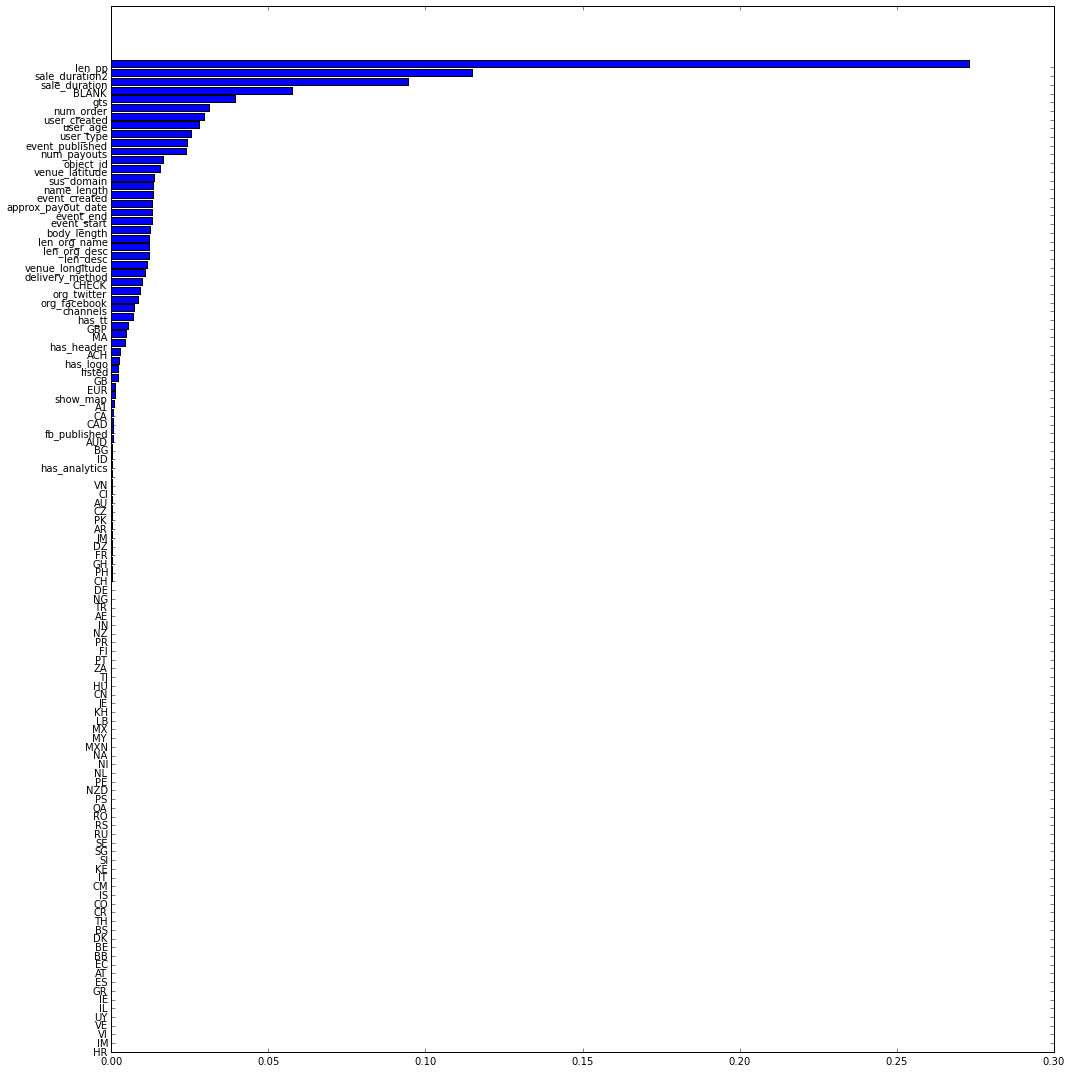

In [356]:
feature_importance(rf, X, y)

In [349]:
X.columns

Index([u'approx_payout_date',        u'body_length',           u'channels',
          u'delivery_method',      u'event_created',          u'event_end',
          u'event_published',        u'event_start',       u'fb_published',
                      u'gts',
       ...
                      u'NZD',           u'len_desc',             u'len_pp',
                   u'has_tt',       u'len_org_desc',              u'BLANK',
                      u'ACH',              u'CHECK',         u'sus_domain',
             u'len_org_name'],
      dtype='object', length=114)

In [361]:
df.iloc[:5, 30:]

,previous_payouts,sale_duration,sale_duration2,show_map,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state,fraud,len_desc
0,[],29,33,1,"[{u'event_id': 527017, u'cost': 25.0, u'availa...",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL,True,3687
1,"[{u'name': u'RUF', u'created': u'2010-10-01 01...",28,28,0,"[{u'event_id': 786878, u'cost': 35.0, u'availa...",149,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC,False,3499
2,"[{u'name': u'Danielle Severn', u'created': u'2...",54,54,0,"[{u'event_id': 787337, u'cost': 93.51, u'avail...",214,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA,False,2601
3,"[{u'name': u'', u'created': u'2010-11-09 01:10...",0,0,0,"[{u'event_id': 885645, u'cost': 25.0, u'availa...",889,1283870102,3,,None,NaN,NaN,None,None,False,12347
4,[{u'name': u'Arts and Business Council or Grea...,63,63,0,"[{u'event_id': 1114349, u'cost': 150.0, u'avai...",35,1288984065,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson,MA,False,2417


In [363]:
yticks = X.columns[np.argsort(model.feature_importances_)].values

In [371]:
features = yticks[-20:]

In [374]:
features

array([u'body_length', u'event_start', u'event_end', u'approx_payout_date',
       u'event_created', u'name_length', 'sus_domain', u'venue_latitude',
       u'object_id', u'num_payouts', u'event_published', u'user_type',
       u'user_age', u'user_created', u'num_order', u'gts', 'BLANK',
       u'sale_duration', u'sale_duration2', 'len_pp'], dtype=object)

In [375]:
X_top20 = X[features]

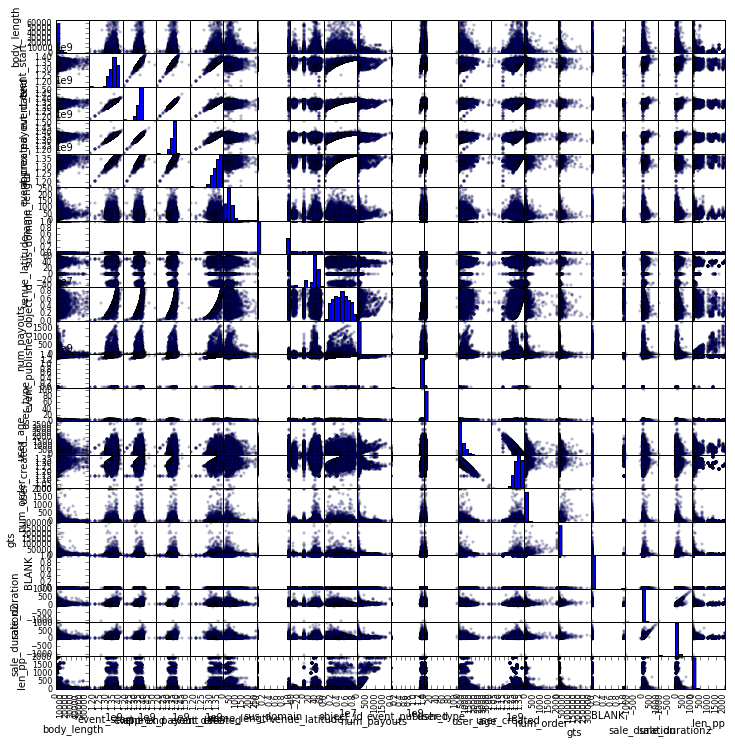

In [388]:
pd.tools.plotting.scatter_matrix(X_top20, alpha=0.2, figsize=(12,12))
plt.show()

In [385]:
accuracy_score(y, y_pred)

0.9983957592243845

In [381]:
y_pred = model.predict(X)

In [387]:
model.score(X, y)

0.9983957592243845

In [395]:
kf = KFold(14337, n_folds=5, shuffle=True)

In [401]:
kfold_accuracy = []

for train_index, test_index in kf:
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf_kfold = RandomForestClassifier()
    model_kfold = rf.fit(X_train, y_train)
    y_pred_kfold = model_kfold.predict(X_test)
    kfold_accuracy.append(accuracy_score(y_test, y_pred_kfold))

print kfold_accuracy

[0.98814504881450493, 0.98047419804741975, 0.98988489710498784, 0.98604813393791424, 0.98360655737704916]


In [392]:
for train_index, test_index in kf:
    print train_index
    print test_index

[    0     1     2 ..., 14334 14335 14336]
[    4     5     6 ..., 14322 14325 14327]
[    0     1     2 ..., 14334 14335 14336]
[   12    16    21 ..., 14317 14324 14330]
[    0     2     4 ..., 14334 14335 14336]
[    1     3    10 ..., 14323 14328 14333]
[    0     1     2 ..., 14333 14334 14336]
[    8     9    13 ..., 14331 14332 14335]
[    1     3     4 ..., 14332 14333 14335]
[    0     2    15 ..., 14329 14334 14336]


In [406]:
float(df[df['fraud']==True].shape[0]) / df[df['fraud']==False].shape[0]

0.09912603495860166

In [408]:
confusion_matrix(y, y_pred)

array([[13042,     2],
       [   21,  1272]])

In [411]:
tf = TfidfVectorizer(stop_words='english')

In [422]:
vectors = tf.fit_transform(df['description'])

In [414]:
tf2 = TfidfVectorizer(stop_words='english', use_idf=False)

In [417]:
org_vectors = tf2.fit_transform(df['org_name'])

In [420]:
org_vectors.shape

(14337, 11001)

In [418]:
payee_vectors = tf2.fit_transform(df['payee_name'])

In [421]:
payee_vectors.shape

(14337, 3543)

In [423]:
pairwise_distances(vectors, metric='cosine')

array([[ -2.22044605e-16,   9.22291580e-01,   7.66294421e-01, ...,
          9.80490210e-01,   6.58662700e-01,   1.00000000e+00],
       [  9.22291580e-01,  -2.22044605e-16,   9.17085142e-01, ...,
          9.82421288e-01,   9.69466684e-01,   1.00000000e+00],
       [  7.66294421e-01,   9.17085142e-01,  -4.44089210e-16, ...,
          9.98777895e-01,   8.26310524e-01,   1.00000000e+00],
       ..., 
       [  9.80490210e-01,   9.82421288e-01,   9.98777895e-01, ...,
         -6.66133815e-16,   9.99016388e-01,   1.00000000e+00],
       [  6.58662700e-01,   9.69466684e-01,   8.26310524e-01, ...,
          9.99016388e-01,  -2.22044605e-16,   1.00000000e+00],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00]])

In [439]:
df_p_org = df[['org_name', 'payee_name']]

In [446]:
df_p_org['corpus'] = df_p_org['org_name'] + ', ' + df_p_org['payee_name'] 
#for row in df_p_org:
#    corpus = [df_p_org['org_name'], df_p_org['payee_name']]

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [463]:
tf_model = TfidfVectorizer()
tf_model.fit(df_p_org['corpus'])

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [467]:
map(lambda x: tf_model.transform(x), df_p_org['payee_name'])

ValueError: Found array with 0 sample(s) (shape=(0, 12087)) while a minimum of 1 is required.

In [457]:
df_p_org.head()

,org_name,payee_name,corpus,vectors
0,Party Starz Ent & Diverse Int'l Group,,"Party Starz Ent & Diverse Int'l Group,","(0, 4692)\t0.27941157707\n (0, 5423)\t0.489..."
1,RUF at Winthrop University,RUF,"RUF at Winthrop University, RUF","(0, 4692)\t0.27941157707\n (0, 5423)\t0.489..."
2,University Preparation School in collaboration...,University Preparation School,University Preparation School in collaboration...,"(0, 4692)\t0.27941157707\n (0, 5423)\t0.489..."
3,,,",","(0, 4692)\t0.27941157707\n (0, 5423)\t0.489..."
4,Arts & Business Council of Greater Boston,Arts and Business Council or Greater Boston,"Arts & Business Council of Greater Boston , Ar...","(0, 4692)\t0.27941157707\n (0, 5423)\t0.489..."


In [481]:
def fuzzy(x):
    return SM(None, x['org_name'], x['payee_name']).ratio()

df_p_org['fuzzy_sim'] = df_p_org.apply(fuzzy, axis=1)

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [482]:
df_p_org.head(10)

,org_name,payee_name,corpus,vectors,fuzzy_sim
0,Party Starz Ent & Diverse Int'l Group,,"Party Starz Ent & Diverse Int'l Group,","(0, 4692)\t0.27941157707\n (0, 5423)\t0.489...",0.000000
1,RUF at Winthrop University,RUF,"RUF at Winthrop University, RUF","(0, 4692)\t0.27941157707\n (0, 5423)\t0.489...",0.206897
2,University Preparation School in collaboration...,University Preparation School,University Preparation School in collaboration...,"(0, 4692)\t0.27941157707\n (0, 5423)\t0.489...",0.394558
3,,,",","(0, 4692)\t0.27941157707\n (0, 5423)\t0.489...",1.000000
4,Arts & Business Council of Greater Boston,Arts and Business Council or Greater Boston,"Arts & Business Council of Greater Boston , Ar...","(0, 4692)\t0.27941157707\n (0, 5423)\t0.489...",0.917647
5,Bluegrass Stallions Basketball,Bluegrass Stallions,"Bluegrass Stallions Basketball, Bluegrass Stal...","(0, 4692)\t0.27941157707\n (0, 5423)\t0.489...",0.775510
6,NABOE Business Owner Networking,,"NABOE Business Owner Networking,","(0, 4692)\t0.27941157707\n (0, 5423)\t0.489...",0.000000
7,The Magnetic Theatre,,"The Magnetic Theatre,","(0, 4692)\t0.27941157707\n (0, 5423)\t0.489...",0.000000
8,,,",","(0, 4692)\t0.27941157707\n (0, 5423)\t0.489...",1.000000
9,The Magnetic Theatre,,"The Magnetic Theatre,","(0, 4692)\t0.27941157707\n (0, 5423)\t0.489...",0.000000


In [483]:
X['fuzzy_sim'] = df_p_org['fuzzy_sim']

In [491]:
X_top20['fuzzy_sim'] = df_p_org['fuzzy_sim']

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [493]:
X_top20.head()

,body_length,event_start,event_end,approx_payout_date,event_created,name_length,sus_domain,venue_latitude,object_id,num_payouts,...,user_type,user_age,user_created,num_order,gts,BLANK,sale_duration,sale_duration2,len_pp,fuzzy_sim
0,3852,1265594400,1265630400,1266062400,1262739706,60,True,25.777471,527017,0,...,1,36,1259613950,0,0.00,1,29,33,0,0.000000
1,3499,1296255600,1296288000,1296720000,1293832670,27,False,32.776566,786878,1,...,3,149,1280942776,23,868.02,0,28,28,49,0.206897
2,2601,1295713800,1295740800,1296172800,1291090956,28,False,33.944201,787337,4,...,3,214,1272559388,19,3500.00,0,54,54,36,0.394558
3,12347,1360702800,1388534400,1388966400,1360681570,21,False,0.000000,885645,16,...,3,889,1283870102,39,1167.35,0,0,0,21,1.000000
4,2417,1297440000,1297468800,1297900800,1291994666,66,False,42.353848,1114349,0,...,3,35,1288984065,30,2313.15,0,63,63,49,0.917647


In [495]:
lg = LogisticRegression()

In [505]:
model = lg.fit(scaled_X20, y)

In [506]:
y_pred = model.predict(scaled_X20)

In [504]:
scaled_X20 = scale(X_top20)

//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:153: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [507]:
accuracy_score(y, y_pred)

0.95612750226686194

In [508]:
model.get_params

<bound method LogisticRegression.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)>

In [509]:
model.coef_

array([[-0.38189045, -0.51909216, -0.0821834 , -0.08354523, -0.15539643,
        -0.35586389,  0.42067288, -0.11226566,  0.31810102, -0.25579076,
        -0.07317808, -1.02443107, -0.38364333,  0.24602006, -4.00476035,
         0.77012491,  0.81220513,  0.36709444, -1.99432719, -5.06004299,
         0.18646656]])

In [511]:
def coef_importance(model, dfX, dfy):
    fi = model.coef_
    yticks = dfX.columns[np.argsort(fi)].values
    fi = sorted(fi)
    x = xrange(len(yticks))
    plt.figure(figsize=(15, 15))
    plt.barh(x, fi)
    plt.yticks(x, yticks)
    plt.tight_layout()

In [518]:
X_top20.columns

Index([       u'body_length',        u'event_start',          u'event_end',
       u'approx_payout_date',      u'event_created',        u'name_length',
               u'sus_domain',     u'venue_latitude',          u'object_id',
              u'num_payouts',    u'event_published',          u'user_type',
                 u'user_age',       u'user_created',          u'num_order',
                      u'gts',              u'BLANK',      u'sale_duration',
           u'sale_duration2',             u'len_pp',          u'fuzzy_sim'],
      dtype='object')

In [524]:
coefs = zip(X_top20.columns, model.coef_[0])

In [528]:
coefs_sorted = sorted(coefs, key = lambda x: abs(x[1]))

In [529]:
coefs_sorted

[(u'event_published', -0.073178084755252351),
 (u'event_end', -0.082183399206021315),
 (u'approx_payout_date', -0.083545230354479583),
 (u'venue_latitude', -0.11226566367722141),
 (u'event_created', -0.15539642998131079),
 ('fuzzy_sim', 0.18646656233095868),
 (u'user_created', 0.24602006408969412),
 (u'num_payouts', -0.2557907632171974),
 (u'object_id', 0.31810101735301538),
 (u'name_length', -0.35586389274445884),
 (u'sale_duration', 0.36709444179475864),
 (u'body_length', -0.38189044534437067),
 (u'user_age', -0.38364333220566932),
 ('sus_domain', 0.4206728821696688),
 (u'event_start', -0.51909216203160258),
 (u'gts', 0.77012490524240862),
 ('BLANK', 0.81220513485133716),
 (u'user_type', -1.0244310685960289),
 (u'sale_duration2', -1.9943271949301462),
 (u'num_order', -4.0047603476473137),
 ('len_pp', -5.0600429853387476)]

In [530]:
odds_ratio = np.exp(model.coef_)

In [531]:
odds_ratio

array([[ 0.68256983,  0.59506052,  0.92110301,  0.91984948,  0.85607574,
         0.70056797,  1.522986  ,  0.89380677,  1.3745151 ,  0.77430396,
         0.9294353 ,  0.35900065,  0.68137441,  1.27892523,  0.01822866,
         2.16003604,  2.2528704 ,  1.44353424,  0.1361052 ,  0.00634529,
         1.20498433]])

In [532]:
odds = zip(X_top20.columns, odds_ratio[0])

In [534]:
odds_sorted = sorted(odds, key = lambda x: abs(x[1]))

In [535]:
odds_sorted

[('len_pp', 0.0063452867527462936),
 (u'num_order', 0.018228657275856069),
 (u'sale_duration2', 0.13610519563427051),
 (u'user_type', 0.3590006540619165),
 (u'event_start', 0.59506052136372256),
 (u'user_age', 0.68137440815249661),
 (u'body_length', 0.6825698278117911),
 (u'name_length', 0.70056796612966121),
 (u'num_payouts', 0.77430396471439267),
 (u'event_created', 0.85607573611762211),
 (u'venue_latitude', 0.89380677396208286),
 (u'approx_payout_date', 0.91984948061223926),
 (u'event_end', 0.92110301364326186),
 (u'event_published', 0.92943529702938421),
 ('fuzzy_sim', 1.2049843295448444),
 (u'user_created', 1.2789252337549151),
 (u'object_id', 1.3745151040921688),
 (u'sale_duration', 1.443534242642428),
 ('sus_domain', 1.5229860010392064),
 (u'gts', 2.160036036760693),
 ('BLANK', 2.2528703963008363)]

In [536]:
confusion_matrix(y, y_pred)

array([[12937,   107],
       [  522,   771]])

In [539]:
svm = SVC()

In [ ]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 10, 0.1]}